In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from deepq import DeepQPlayer,RandomPlayer,QPlayer,Board,SinglePredictionQPlayer,generate_random_board,visualize,MonteCarloPlayer,MultiPredictionQPlayer
from IPython.display import clear_output
import time

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
q1 = SinglePredictionQPlayer(player_symbol=1,name='Q1')
q1.loadPolicy('QNetworks/Q_Q_Single_Encoder')

Q1 Loaded Q and Q Prime networks from file QNetworks/Q_Q_Single_Encoder


In [5]:
%%time
winners = []

r2 = RandomPlayer(player_symbol=-1)

b1 = Board(q1,r2,num_rows=6,num_cols=7)
for i in range(1000):
    q1.epsilon = 0.0
    winners.append(b1.play_agents(verbose=False))
    b1.reset()
    q1.reset()


winners = [i if i is not None else 0 for i in winners]
print(np.unique(winners,return_counts=True))



(array([-1,  1]), array([  1, 999]))
CPU times: user 13 s, sys: 1.02 s, total: 14 s
Wall time: 13.3 s


The Q player beat the random agent 99.99% of the time

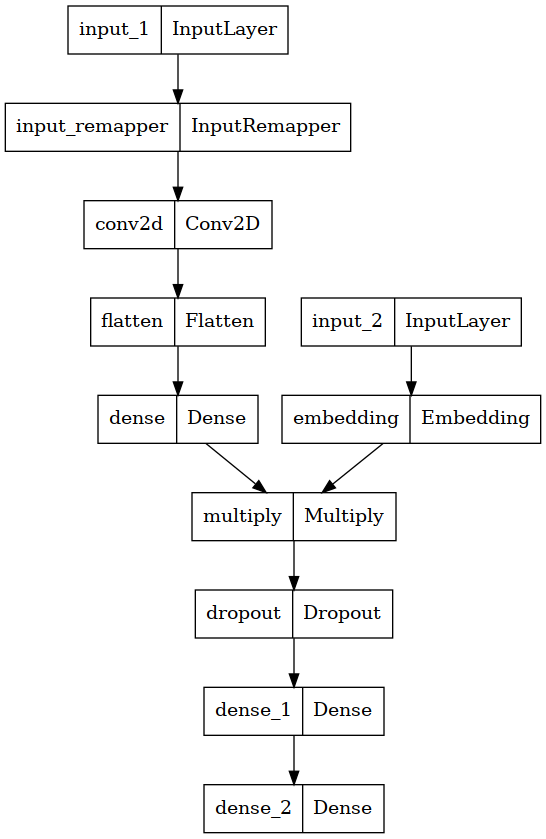

In [6]:
tf.keras.utils.plot_model(q1.q_network)

QFunction: [0.19, 0.24, 0.25, 0.29, 0.25, 0.23, 0.19]
Targets (alpha=0): [0. 0. 0. 0. 0. 0. 0.]
Targets (alpha=1): [0.14 0.13 0.21 0.21 0.19 0.13 0.14]


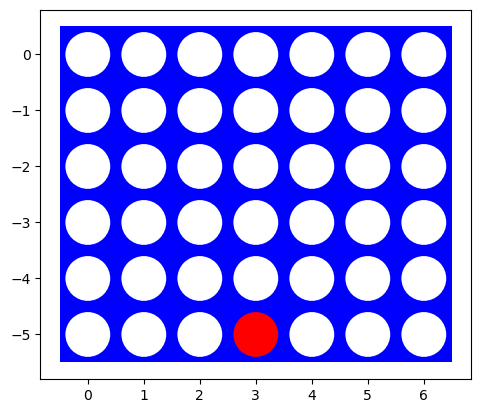

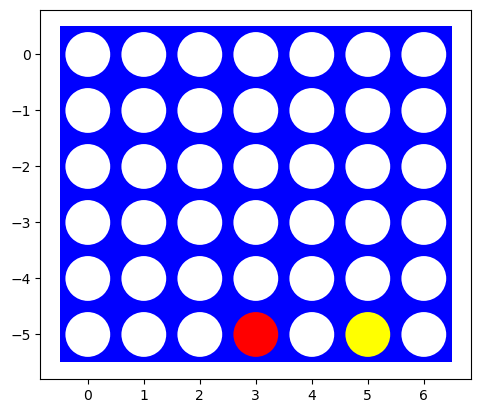


QFunction: [0.28, 0.33, 0.41, 0.32, 0.32, 0.26, 0.25]
Targets (alpha=0): [0.   0.1  0.1  0.05 0.05 0.   0.  ]
Targets (alpha=1): [0.23 0.32 0.2  0.21 0.22 0.14 0.16]


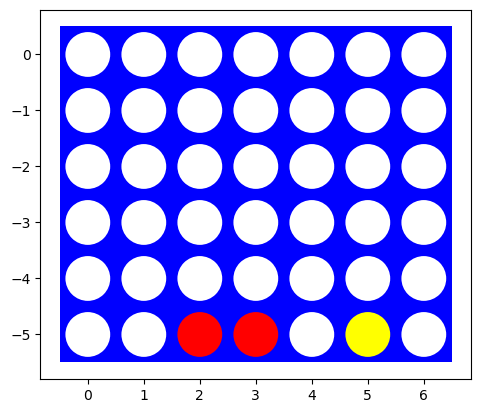

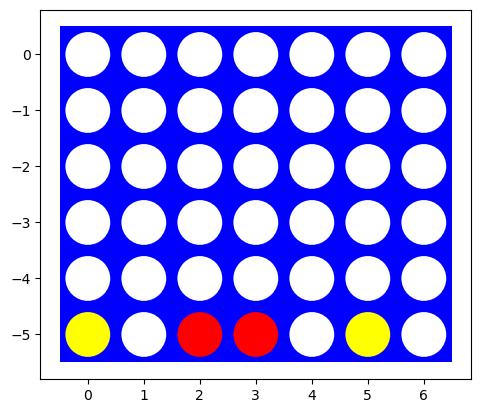


QFunction: [0.34, 0.5, 0.39, 0.42, 0.45, 0.37, 0.34]
Targets (alpha=0): [0.05 0.1  0.15 0.1  0.1  0.05 0.  ]
Targets (alpha=1): [0.26 0.17 0.25 0.25 0.16 0.25 0.17]


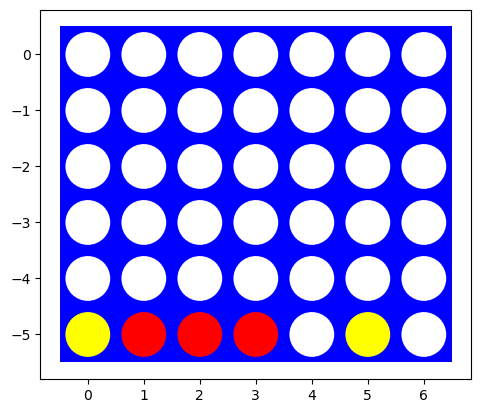

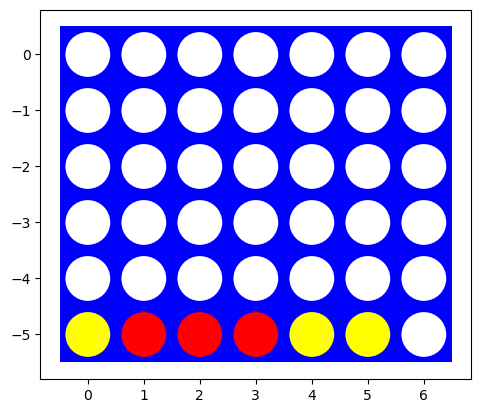


QFunction: [0.23, 0.29, 0.3, 0.34, 0.28, 0.23, 0.23]
Targets (alpha=0): [0.05 0.1  0.1  0.15 0.1  0.05 0.05]
Targets (alpha=1): [0.19 0.2  0.21 0.23 0.15 0.18 0.14]


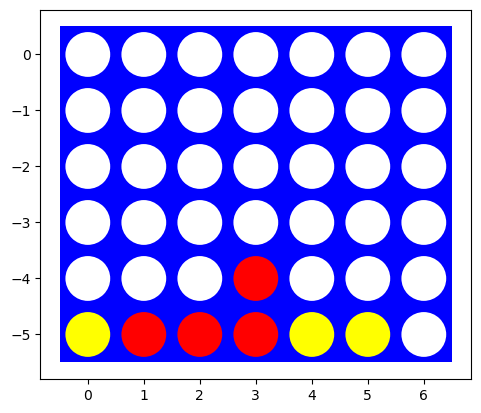

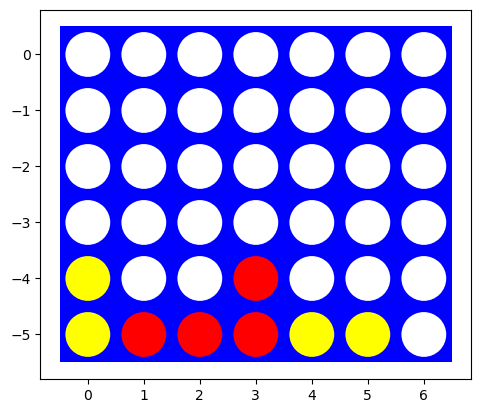


QFunction: [0.31, 0.37, 0.41, 0.46, 0.4, 0.33, 0.29]
Targets (alpha=0): [0.2  0.2  0.34 0.15 0.29 0.2  0.15]
Targets (alpha=1): [0.22 0.24 0.31 0.2  0.24 0.32 0.22]


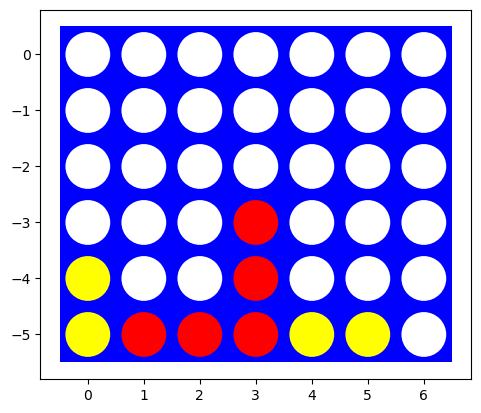

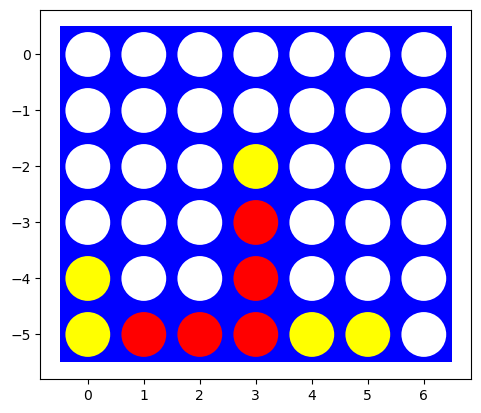


QFunction: [0.26, 0.33, 0.39, 0.3, 0.39, 0.31, 0.32]
Targets (alpha=0): [ 0.2   0.2   0.48  0.1   0.02  0.24 -0.22]
Targets (alpha=1): [0.21 0.3  0.26 0.17 0.33 0.32 0.18]


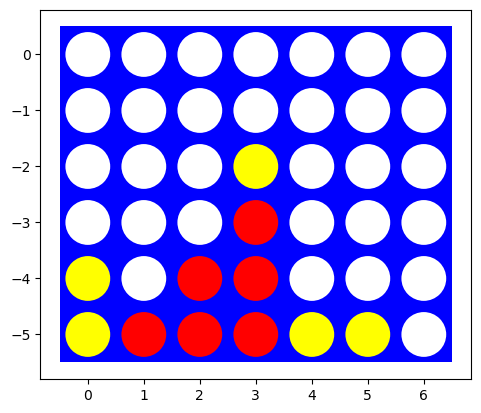

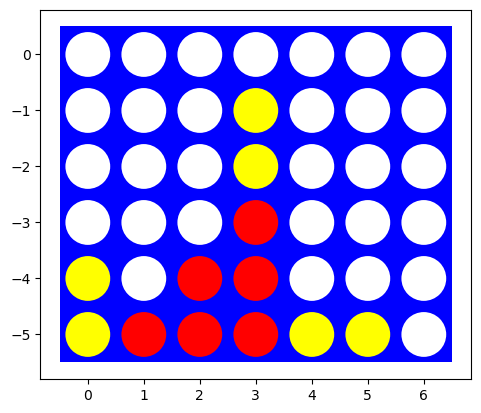


QFunction: [0.48, 0.56, 0.52, 0.46, 0.69, 0.52, 0.5]
Targets (alpha=0): [0.55 0.62 0.38 0.52 0.74 0.52 0.55]
Targets (alpha=1): [0.28 0.28 0.32 0.2  0.49 0.32 0.2 ]


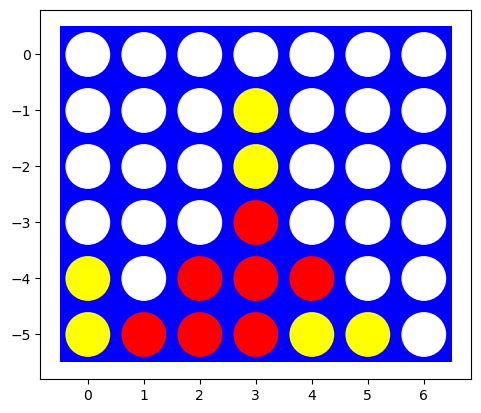

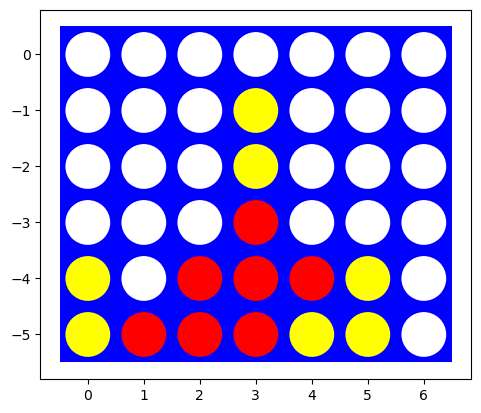


QFunction: [0.61, 0.98, 0.56, 0.58, 0.72, 0.55, 0.55]
Targets (alpha=0): [0.34 1.   0.55 0.24 0.74 0.62 0.29]
Targets (alpha=1): [0.31 1.   0.46 0.24 0.5  0.24 0.23]


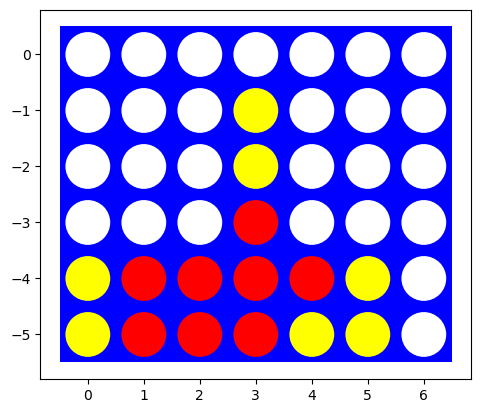


Player 1 Wins!


In [7]:
from deepq import GreedyPlayer
q1.reset()

q1.epsilon = 0.0

gp = GreedyPlayer(player_symbol=-1)

b2 = Board(q1,gp,num_rows=6,num_cols=7)
boards = b2.play_agents(return_boards=False,verbose=2)


QFunction: [0.19, 0.24, 0.25, 0.29, 0.25, 0.23, 0.19]
Targets (alpha=0): [0. 0. 0. 0. 0. 0. 0.]
Targets (alpha=1): [0.15 0.17 0.22 0.22 0.14 0.19 0.14]


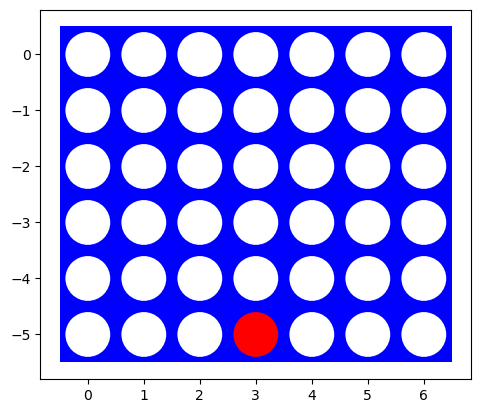

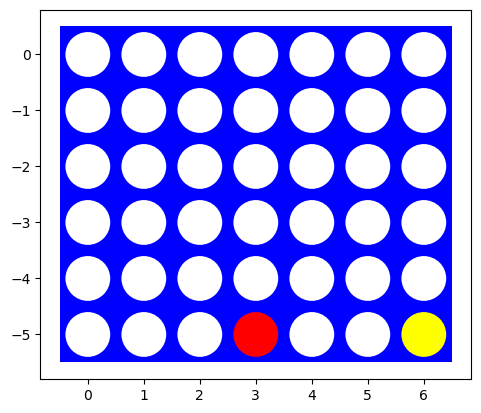


QFunction: [0.31, 0.34, 0.45, 0.33, 0.41, 0.32, 0.26]
Targets (alpha=0): [0.   0.05 0.1  0.05 0.05 0.   0.  ]
Targets (alpha=1): [0.21 0.35 0.2  0.22 0.34 0.25 0.15]


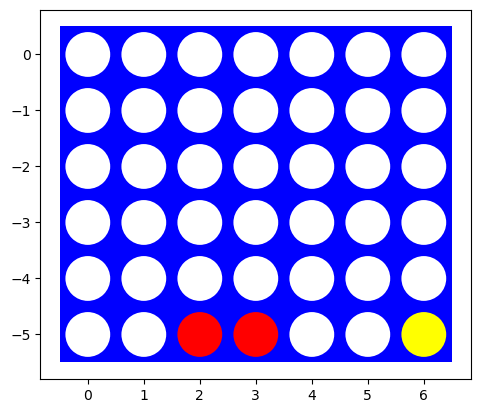

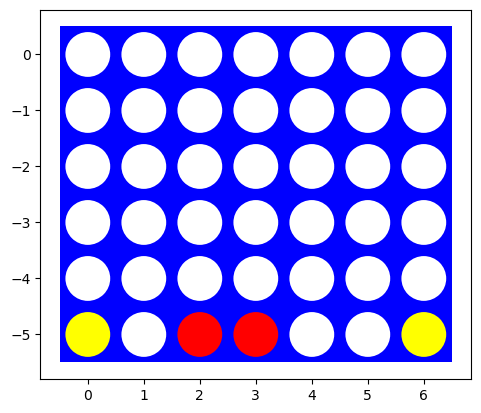


QFunction: [0.37, 0.5, 0.41, 0.44, 0.67, 0.44, 0.37]
Targets (alpha=0): [0.05 0.1  0.2  0.15 0.4  0.05 0.05]
Targets (alpha=1): [0.17 0.17 0.25 0.23 0.5  0.16 0.34]


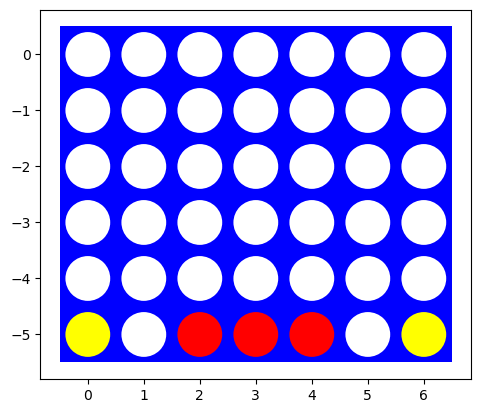

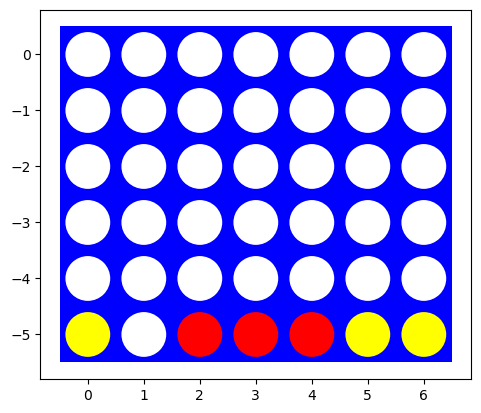


QFunction: [0.51, 1.0, 0.52, 0.56, 0.53, 0.44, 0.48]
Targets (alpha=0): [0.1  1.   0.2  0.24 0.2  0.1  0.1 ]
Targets (alpha=1): [0.19 1.   0.23 0.25 0.24 0.24 0.17]


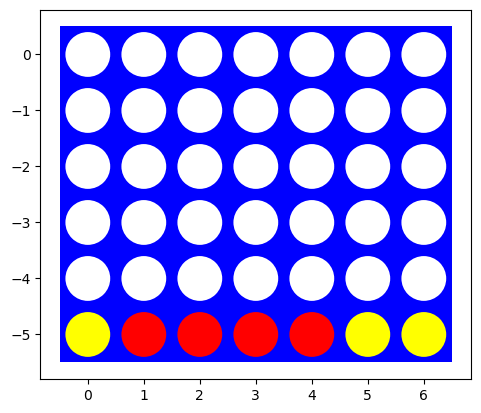


Player 1 Wins!


1

In [8]:
q1.reset()
q1.epsilon = 0.0
b2.reset()
b2.play_agents(verbose=2)

QFunction: [0.19, 0.24, 0.25, 0.29, 0.25, 0.23, 0.19]
Targets (alpha=0): [0. 0. 0. 0. 0. 0. 0.]
Targets (alpha=1): [0.14 0.15 0.2  0.23 0.19 0.12 0.14]


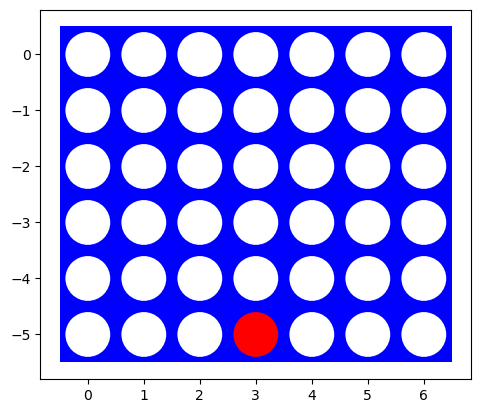


[-999, -999, -999, -999, -999, -999, -999]


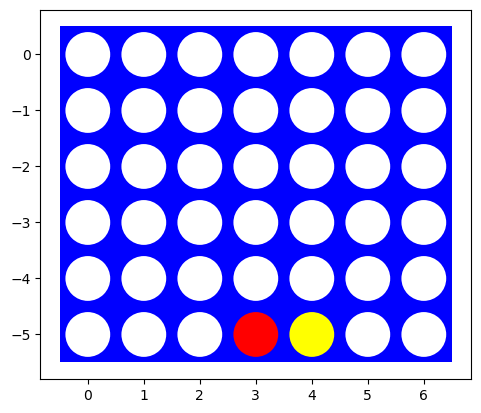


QFunction: [0.26, 0.3, 0.29, 0.31, 0.26, 0.23, 0.22]
Targets (alpha=0): [ 0.05  0.    0.05  0.05  0.05 -0.05  0.  ]
Targets (alpha=1): [0.22 0.22 0.19 0.22 0.18 0.15 0.15]


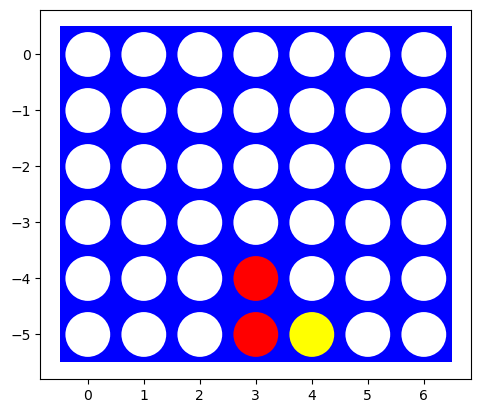


[-999, -999, -999, -999, -999, -999, -999]


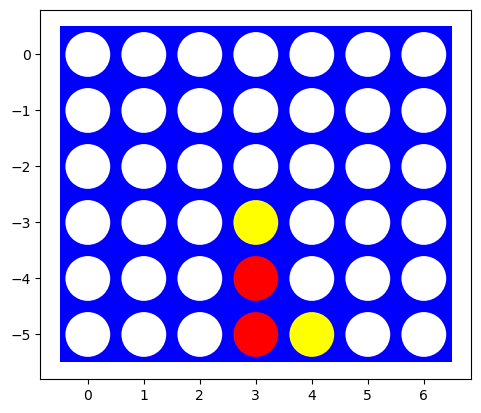


QFunction: [0.27, 0.3, 0.31, 0.26, 0.24, 0.23, 0.22]
Targets (alpha=0): [ 0.    0.    0.   -0.1   0.15 -0.1  -0.05]
Targets (alpha=1): [0.21 0.23 0.19 0.15 0.16 0.16 0.14]


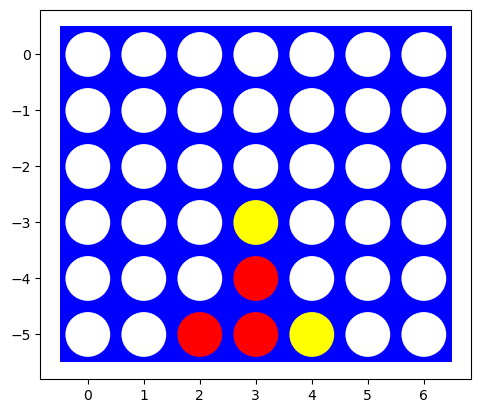


[-999, -999, -999, -999, -999, -999, -999]


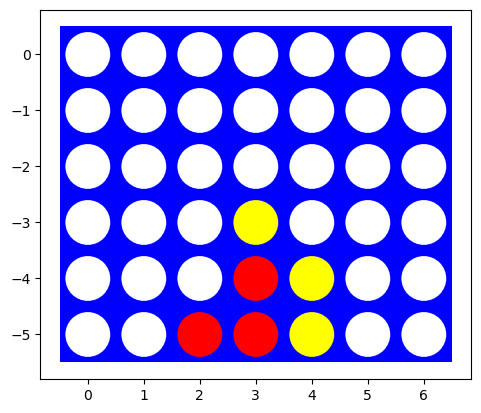


QFunction: [0.37, 0.41, 0.27, 0.28, 0.28, 0.27, 0.21]
Targets (alpha=0): [-0.1   0.   -0.44 -0.31  0.31  0.   -0.55]
Targets (alpha=1): [0.19 0.17 0.27 0.07 0.19 0.2  0.21]


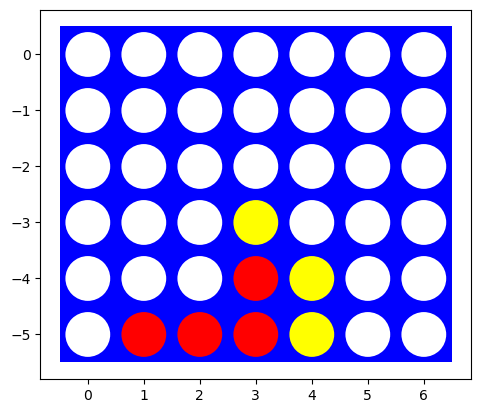


[-999, -999, -999, -999, -999, -999, -999]


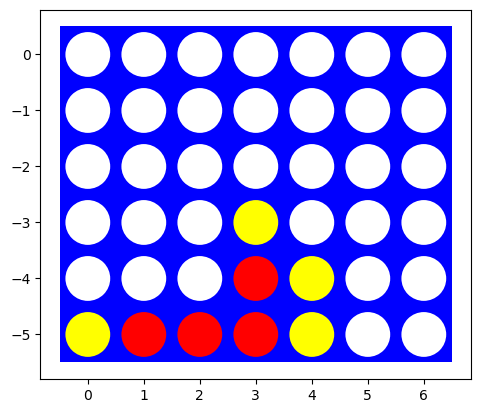


QFunction: [0.29, 0.3, 0.34, 0.3, 0.28, 0.27, 0.25]
Targets (alpha=0): [-0.05 -0.44 -0.4   0.05  0.4   0.1  -0.05]
Targets (alpha=1): [0.25 0.1  0.2  0.18 0.12 0.13 0.13]


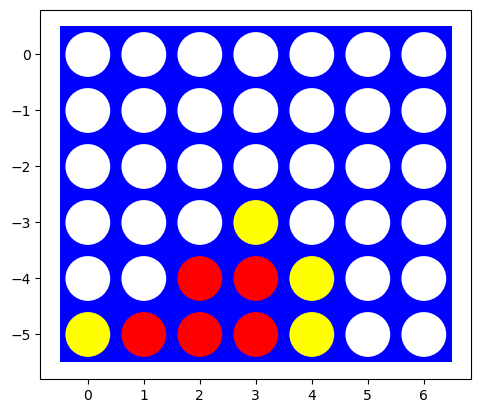


[-999, -999, -999, -999, -999, -999, -999]


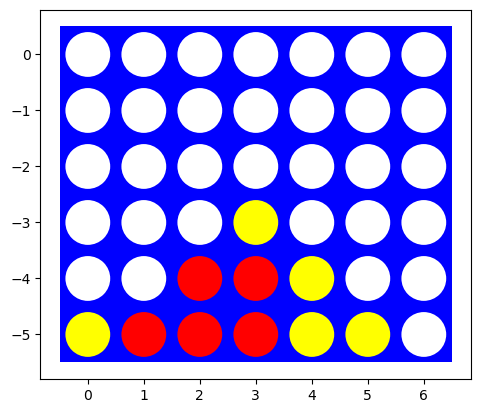


QFunction: [0.38, 0.39, 0.23, 0.27, 0.29, 0.26, 0.27]
Targets (alpha=0): [-0.22 -0.12 -1.   -0.31  0.2  -0.36 -0.17]
Targets (alpha=1): [ 0.02  0.2  -1.    0.23  0.21  0.14  0.21]


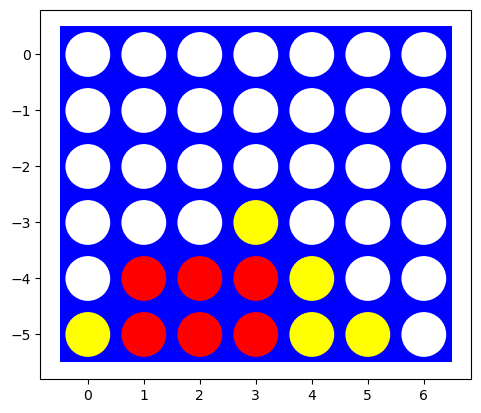


[-999, -999, -999, -999, -999, -999, -999]


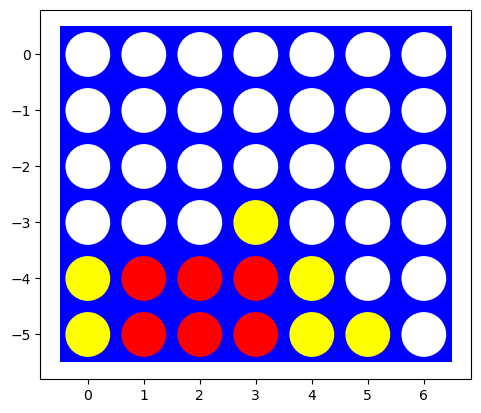


QFunction: [0.23, 0.4, 0.3, 0.24, 0.26, 0.17, 0.19]
Targets (alpha=0): [-0.12  0.2  -1.   -0.27  0.24 -0.12 -0.12]
Targets (alpha=1): [ 0.06  0.13 -1.    0.2   0.17  0.22  0.09]


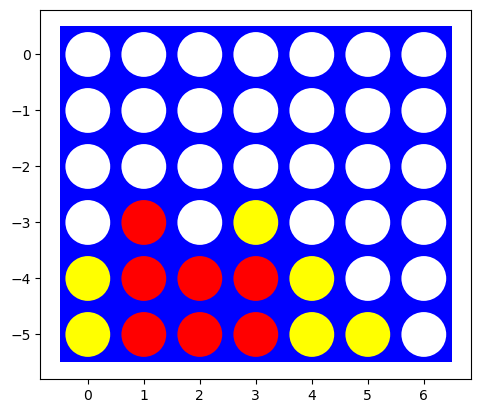


[-999, -999, -999, -999, -999, -999, -999]


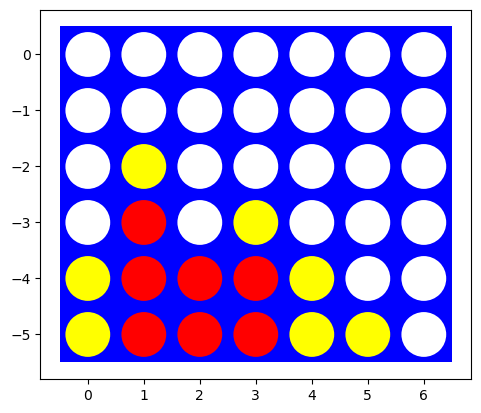


QFunction: [0.24, 0.13, 0.1, 0.19, 0.25, 0.16, 0.2]
Targets (alpha=0): [-0.17 -0.22 -1.    0.1   0.24 -0.27  0.2 ]
Targets (alpha=1): [ 0.12  0.11 -1.    0.28  0.14  0.31  0.28]


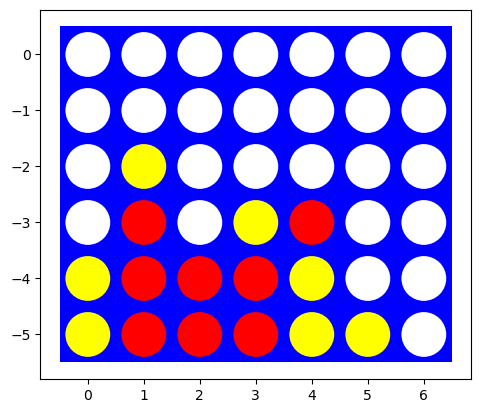


[-999, -999, -999, -999, -999, -999, -999]


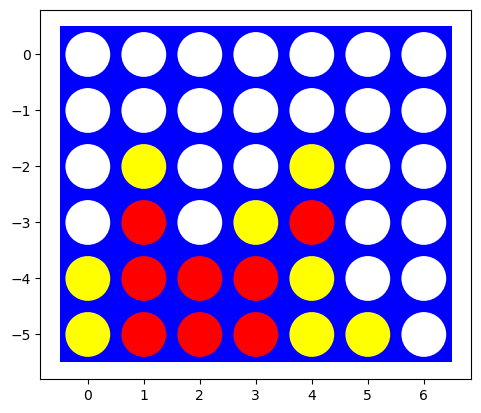


QFunction: [0.18, 0.09, 0.04, 0.13, 0.03, 0.12, 0.1]
Targets (alpha=0): [ 0.1   0.52 -1.    0.55  0.15  0.48  0.4 ]
Targets (alpha=1): [ 0.1   0.1  -1.    0.    0.03  0.06  0.2 ]


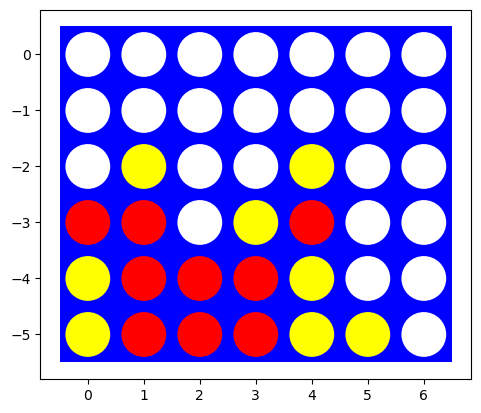


[-999, -999, -999, -999, -999, -999, -999]


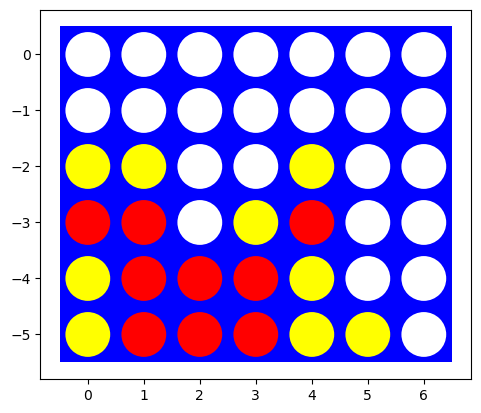


QFunction: [0.19, -0.03, -0.09, -0.01, -0.06, 0.08, -0.04]
Targets (alpha=0): [-0.6   0.2  -1.    0.29 -0.22  0.15  0.05]
Targets (alpha=1): [ 0.03  0.03 -1.    0.23  0.07  0.12  0.05]


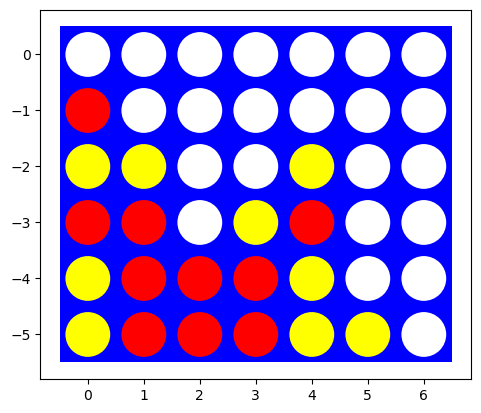


[-999, -999, -999, -999, -999, -999, -999]


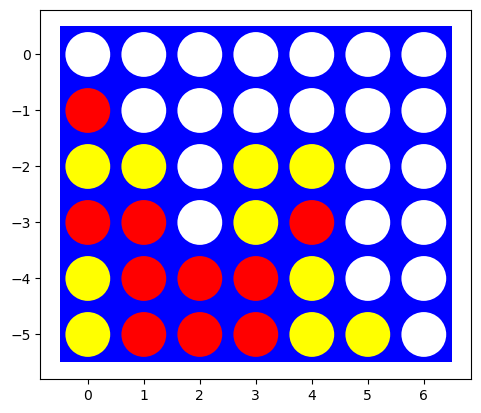


QFunction: [-0.1, -0.31, -0.29, -0.43, -0.36, -0.19, -0.38]
Targets (alpha=0): [-0.81 -0.54 -1.   -0.54 -0.64 -0.64 -0.64]
Targets (alpha=1): [-0.08  0.03 -1.    0.19 -0.13  0.5   0.02]


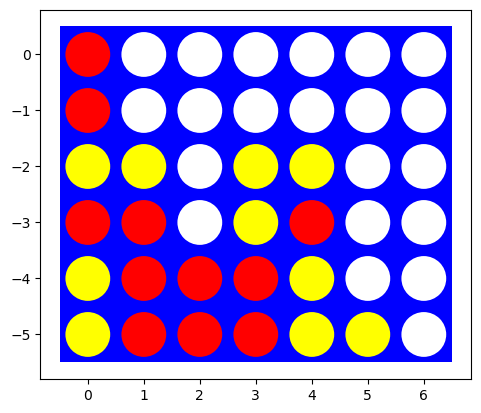


[-999, -999, -999, -999, -999, -999, -999]


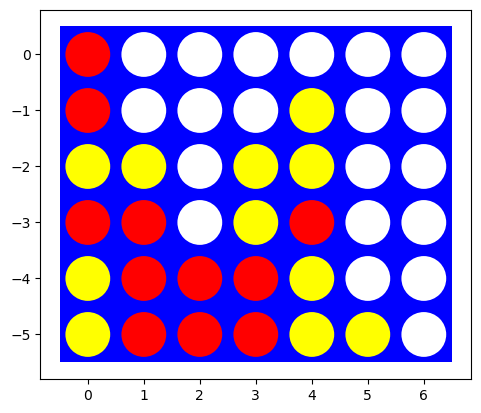


QFunction: [-0.08, -0.31, -0.27, -0.45, -0.36, -0.16, -0.35]
Targets (alpha=0): [-0.66 -0.57 -1.   -0.6  -0.64 -0.64 -0.66]
Targets (alpha=1): [-0.14  0.03 -1.    0.07  0.02  0.5  -0.14]


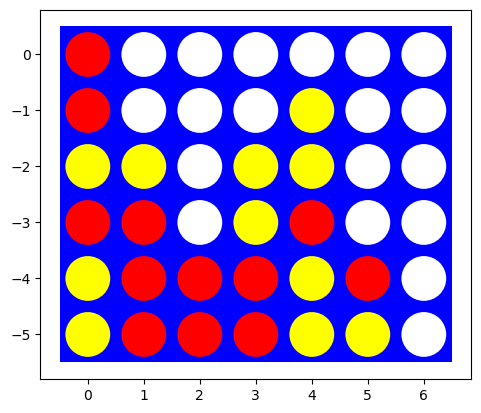


[-999, -999, -999, -999, -999, -999, -999]


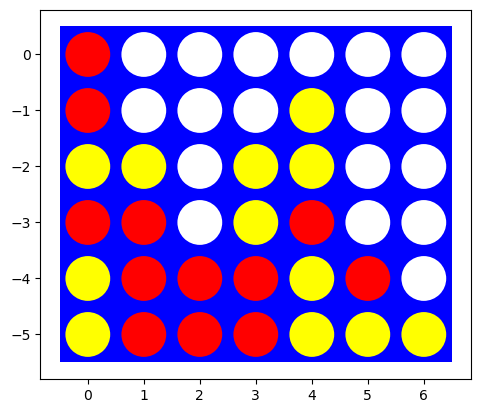


QFunction: [-0.05, -0.22, -0.2, -0.35, -0.31, 0.17, -0.3]
Targets (alpha=0): [-0.69 -0.6  -1.   -0.81 -0.79 -0.95 -0.64]
Targets (alpha=1): [ 0.11  0.04 -1.    0.07 -0.01 -0.13  0.1 ]


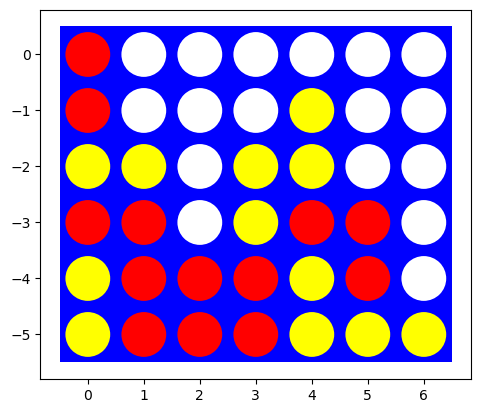


[-999, -999, -999, -999, -999, -999, -999]


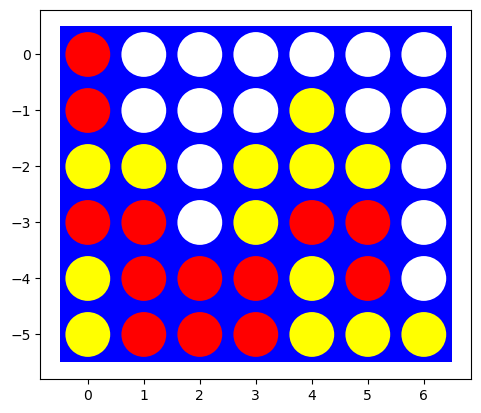


QFunction: [-0.37, -0.44, -0.26, -0.49, -0.49, -0.36, -0.53]
Targets (alpha=0): [-0.98 -0.98 -1.   -0.94 -0.98 -0.97 -0.97]
Targets (alpha=1): [-0.14  0.09 -1.   -0.13 -0.14 -0.18 -0.14]


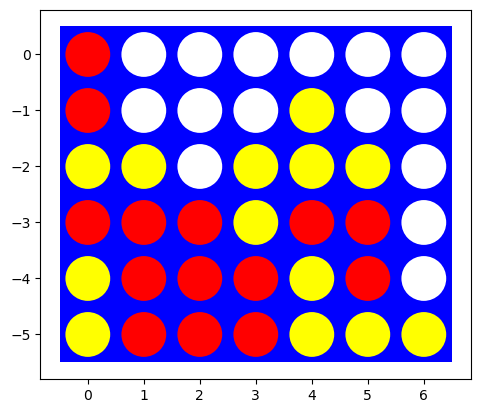


[-999, -999, -999, -999, -999, -999, -999]


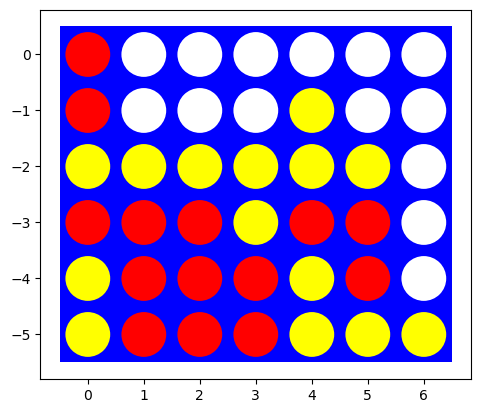


Player -1 Wins!


-1

In [9]:
from deepq import HumanPlayer
b3 = Board(q1,HumanPlayer(player_symbol=-1))
b3.play_agents(verbose=2)